<a href="https://colab.research.google.com/github/monroews/About/blob/master/TE_Filter_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# TE Filter Model

Corrected to eliminate artificial dependencies on London Van der Waals forces that were created by including those forces in multiple dimensionless groups that canceled out.

Tufenkji, N. and M. Elimelech (2004). "Correlation equation for predicting single-collector efficiency in physicochemical filtration in saturated porous media." Environmental-Science-and-Technology 38(2): 529-536.

$$\eta_{0}=\eta_{\mathrm{D}}+\eta_{\mathrm{I}}+\eta_{\mathrm{G}}$$

$$\eta_{\mathrm{D}}=2.4 A_{\mathrm{S}}^{1 / 3} N_{\mathrm{R}}^{-0.081} N_{\mathrm{Pe}}^{-0.715} N_{\mathrm{vdW}}^{0.052}$$

$$\eta_{\mathrm{I}}=0.55 A_{\mathrm{S}} N_{\mathrm{R}}^{1.55} N_{\mathrm{Pe}}^{-0.125} N_{\mathrm{vdW}}^{0.125}$$

$$\eta_{\mathrm{G}}=0.475 N_{\mathrm{R}}^{-1.35} N_{\mathrm{Pe}}^{-1.11} N_{\mathrm{vdW}}^{0.053} N_{\mathrm{gr}}^{1.11}$$

The TE model includes artificial dependency on London Van der Waals forces. That dependency can be factored out of the equations to obtain a simpler set.

$$\eta_{\mathrm{R}}\left(\mathrm{d}_{\mathrm{p}}\right)=\frac{1}{21.5} \mathrm{A}_{\mathrm{S}} \cdot \mathrm{N}_{\mathrm{R}}^{1.425}$$



# Model Inputs

In [0]:
!pip install aguaclara
!pip install molmass

     |████████████████████████████████| 92kB 6.8MB/s 
     |████████████████████████████████| 163kB 34.7MB/s 
  Created wheel for aguaclara: filename=aguaclara-0.2.1-cp36-none-any.whl size=99466 sha256=1bac6cb7b12a291303309930fcb2ec6b12f0c4850586c46fedc2206fbeba7638
  Stored in directory: /root/.cache/pip/wheels/7f/ff/4f/10d76e6a261d392aefbdf6ce8d3d5519e924dc334b102ca49b
  Created wheel for pint: filename=Pint-0.8.1-py2.py3-none-any.whl size=134156 sha256=45b715aa690ecf93bd09e2584c7635e0823c79bcda4b31dbe5a9f5a8345dcbaa
  Stored in directory: /root/.cache/pip/wheels/b4/56/36/7c4d6a4e3660e233b95e3b0482551915cb184abca0f93ee1dd
Successfully built aguaclara pint
     |████████████████████████████████| 71kB 3.8MB/s 


In [0]:
import aguaclara as ac
from aguaclara.core.units import unit_registry as u
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import pandas as pd

In [0]:

# rho_p = 2650 * u.kg/u.m**3
v_a = 1.8 * u.mm/u.s
Temp = 20 * u.degC 
z = 20 * u.cm
d_c = 0.5 * u.mm
alpha = 1
porosity = 0.4

bacteria = ac.Material('bacteria', 10**-6 * u.m, 1005 * u.kg/u.m**3, None)


# Dimensionless groups

In [0]:
def Pi_R(d_c,d_p):
  return (d_p/d_c).to(u.dimensionless)

def Pi_z(d_c,z,porosity):
  return (z/d_c * 3 * (1-porosity)/2/np.log(10)).to(u.dimensionless)

def Pi_Br(d_c,d_p,v_a,Temp):
  return (u.boltzmann_constant*Temp/(3*np.pi*ac.viscosity_dynamic_water(Temp)*d_p*v_a*d_c)).to(u.dimensionless)

def Pi_g(d_c,d_p,v_a,Temp,DIM_FRACTAL,material):
  ConcAl = 0 * u.mg/u.L
  ConcClay = 1 * u.mg/u.L 
  coag = ac.PACl
  return d_p**2 *(ac.dens_floc(ConcAl, ConcClay, DIM_FRACTAL, d_p, coag, material, Temp)-ac.density_water(Temp))*u.gravity/(18*ac.viscosity_dynamic_water(Temp)*v_a)

# def Re_p(d_c,v_a,Temp):
#   return (v_a * d_c/ac.viscosity_kinematic_water(Temp)).to(u.dimensionless)

def A_s(porosity):
  x = (1-porosity)**(1/3)
  return 2 * (1-x**5)/(2-3*x + 3*x**5 - 2*x**6)

#Transport due to Brownian motion, gravity, and interception

def T_Br(d_c,d_p,v_a,Temp,porosity):
  return 3/4 * A_s(porosity)**(1/3) * Pi_R(d_c,d_p)**(-1/6) * Pi_Br(d_c,d_p,v_a,Temp)**(2/3)

def T_In(d_c,d_p,porosity):
  return 1/21.5 * A_s(porosity) * Pi_R(d_c,d_p)**1.425

def T_g(d_c,d_p,v_a,Temp,DIM_FRACTAL,material):
  return 0.31 * Pi_g(d_c,d_p,v_a,Temp,DIM_FRACTAL,material)

def pC_Br(d_c,d_p,v_a,Temp,porosity,alpha):
  return Pi_z(d_c,z,porosity) * alpha * T_Br(d_c,d_p,v_a,Temp,porosity)

def pC_In(d_c,d_p,z,porosity,alpha):
  return Pi_z(d_c,z,porosity) * alpha * T_In(d_c,d_p,porosity)

def pC_g(d_c,d_p,v_a,Temp,DIM_FRACTAL,material):
  return Pi_z(d_c,z,porosity) * alpha * T_g(d_c,d_p,v_a,Temp,DIM_FRACTAL,material)

def pC_T(d_c,d_p,v_a,Temp,porosity,alpha, DIM_FRACTAL,material):
  return Pi_z(d_c,z,porosity) * alpha * (T_Br(d_c,d_p,v_a,Temp,porosity)+T_In(d_c,d_p,porosity)+T_g(d_c,d_p,v_a,Temp,DIM_FRACTAL,material))


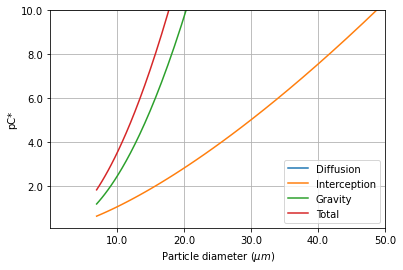

pC* for flocs of clay with a fractal dimension of 3


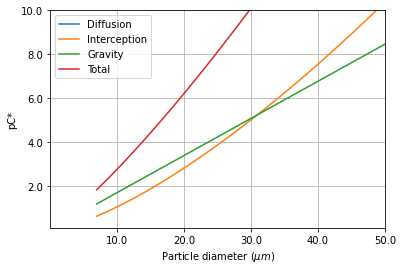

pC* for flocs of clay with a fractal dimension of 2


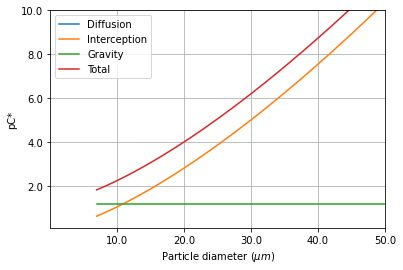

pC* for flocs of clay with a fractal dimension of 1


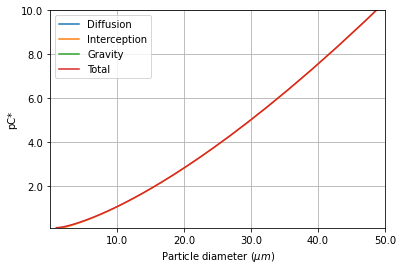

pC* for flocs of bacteria with a fractal dimension of 2


In [0]:
def plot_TE(d_c,v_a,Temp,porosity,alpha,DIM_FRACTAL,material):
  n = 50
  d_p = np.logspace(np.log10((material.Diameter.to(u.um).magnitude)),2,n) * u.um 
  y_Br = np.empty(n)
  y_In = np.empty(n)
  y_g = np.empty(n)
  y_T = np.empty(n)
  for i in range(n):
    y_Br[i] = pC_Br(d_c,d_p[i],v_a,Temp,porosity,alpha)
    y_In[i] = pC_In(d_c,d_p[i],z,porosity,alpha)
    y_g[i] = pC_g(d_c,d_p[i],v_a,Temp,DIM_FRACTAL,material)
    y_T[i] = pC_T(d_c,d_p[i],v_a,Temp,porosity,alpha,DIM_FRACTAL,material)
  plt.plot(d_p,y_Br)
  plt.plot(d_p,y_In)
  plt.plot(d_p,y_g)
  plt.plot(d_p,y_T)
  plt.xscale("linear")
  plt.yscale("linear")
  plt.legend(['Diffusion','Interception','Gravity','Total'])
  plt.ylim(ymin=0.1,ymax=10)
  plt.xlim(xmin=0.1,xmax=50)
  plt.grid(which='both',axis='both')
  plt.ylabel('pC*')
  plt.xlabel(r'Particle diameter ($\mu m$)')
  plt.gca().yaxis.set_major_formatter(ticker.StrMethodFormatter("{x}"))
  plt.gca().xaxis.set_major_formatter(ticker.StrMethodFormatter("{x}"))
  plt.show()
  print('pC* for flocs of',material.name.lower(), 'with a fractal dimension of',DIM_FRACTAL)

plot_TE(d_c,v_a,Temp,porosity,alpha,3,ac.Clay)
plot_TE(d_c,v_a,Temp,porosity,alpha,2,ac.Clay)
plot_TE(d_c,v_a,Temp,porosity,alpha,1,ac.Clay)
plot_TE(d_c,v_a,Temp,porosity,alpha,2,bacteria)